In [3]:
'''Adapted from https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch and https://github.com/piEsposito/pytorch-lstm-by-hand'''

'Adapted from https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch and https://github.com/piEsposito/pytorch-lstm-by-hand'

In [ ]:
'''IMDB Reviews Dataset downloaded from https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'''

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from utils import ensure_reproducibility, snake_func
import math
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ensure_reproducibility(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
base_csv = 'data/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
X,y = df['review'].values, df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(f'Shape of training data is {X_train.shape}')
print(f'Shape of test data is {X_test.shape}')

Shape of training data is (37500,)
Shape of test data is (12500,)


In [6]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

In [7]:
def tokenize(X_train, y_train, X_test, y_test):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in X_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokkenize
    final_list_train, final_list_test = [],[]
    for sent in X_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in X_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_test] 
    return np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test), onehot_dict

In [8]:
X_train, y_train, X_test, y_test, vocab = tokenize(X_train, y_train, X_test,y_test)

In [9]:
print(f'Size of vocabulary is {len(vocab)}')

Size of vocabulary is 1000


In [10]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [11]:
X_train_pad = padding_(X_train, 500)
X_test_pad = padding_(X_test, 500)

In [12]:
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 64

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [13]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([64, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 171,  89, 882],
        [  0,   0,   0,  ..., 200, 460, 253],
        [  0,   0,   0,  ..., 648,  14,   2],
        ...,
        [  0,   0,   0,  ...,   5,   1,  22],
        [  0,   0,   0,  ...,  98, 305,   8],
        [  0,   0,   0,  ...,  56, 197, 537]], dtype=torch.int32)
Sample input: 
 tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.int32)


Implementation of LSTM Cell from scratch

In [77]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz, activation):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.activation = activation
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            if self.activation == "tanh":
                h_t = o_t * torch.tanh(c_t)
            elif self.activation == "snake":
                h_t = o_t * snake_func(c_t, a=1)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [25]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, lstm_activation):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.lstm = CustomLSTM(embedding_dim, hidden_dim, activation=lstm_activation)
        self.fc1 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x_ = self.embedding(x)
        x_, (h_n, c_n) = self.lstm(x_)
        x_ = (x_[:, -1, :])
        x_ = self.fc1(x_)
        return torch.sigmoid(x_)

<h2>Training LSTM with usual tanh activation

In [16]:
lr=0.001
epochs=5

criterion = nn.BCELoss()

net_tanh = Net(vocab_size=len(vocab)+1, embedding_dim=32, hidden_dim=32, lstm_activation='tanh')
net_tanh.to(device)

optimizer = torch.optim.Adam(net_tanh.parameters(), lr=lr)

In [17]:
train_accs_tanh = []
test_accs_tanh = []
for epoch in tqdm(range(epochs)):

    running_loss = 0.
    num_steps = 0
    correct = 0
    for i, (datapoints, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        preds = net_tanh(datapoints.long().to(device))
        loss = criterion(preds.squeeze(), labels.float().to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_steps += 1
        
        correct += torch.sum(torch.where(preds>=0.5, 1., 0.).squeeze() == labels.cuda())
    
    train_acc = correct/(num_steps*train_loader.batch_size)

    print(f"Train acc = {train_acc}")
    print(f"Train Loss = {running_loss/num_steps}")

    train_accs_tanh.append(train_acc)

    running_loss = 0.
    num_steps = 0
    correct = 0
    for i, (datapoints, labels) in enumerate(test_loader):
        
        with torch.no_grad():
        
            preds = net_tanh(datapoints.long().to(device))
            loss = criterion(preds.squeeze(), labels.float().to(device))

        running_loss += loss.item()
        num_steps += 1
        
        correct += torch.sum(torch.where(preds>=0.5, 1., 0.).squeeze() == labels.cuda())

    test_acc = correct/(num_steps*test_loader.batch_size)

    print(f"Test acc = {test_acc}")
    print(f"Test Loss = {running_loss/num_steps}")

    test_accs_tanh.append(test_acc)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Train acc = 0.6964057087898254
Train Loss = 0.563822156485844


 20%|████████████████▌                                                                  | 1/5 [07:18<29:14, 438.65s/it]

Test acc = 0.7965561151504517
Test Loss = 0.43902967961467043
Train acc = 0.8286582231521606
Train Loss = 0.39398368793848026


 40%|█████████████████████████████████▏                                                 | 2/5 [14:19<21:39, 433.25s/it]

Test acc = 0.8309151530265808
Test Loss = 0.38626993455144826
Train acc = 0.8512958288192749
Train Loss = 0.351597265833067


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [21:19<14:18, 429.42s/it]

Test acc = 0.84574294090271
Test Loss = 0.3549868865888946
Train acc = 0.8590283393859863
Train Loss = 0.3330641219538633


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [28:20<07:06, 426.83s/it]

Test acc = 0.8482939600944519
Test Loss = 0.3440147135786864
Train acc = 0.8687606453895569
Train Loss = 0.31414787121651117


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [35:22<00:00, 424.49s/it]

Test acc = 0.8525190949440002
Test Loss = 0.33570862895980175


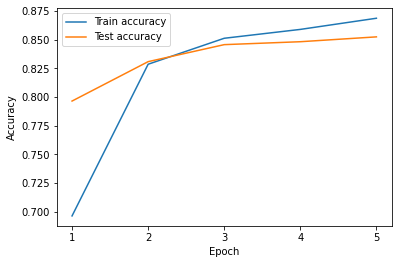

In [18]:
plt.plot(range(1, epochs+1), train_accs_tanh, label="Train accuracy")
plt.plot(range(1, epochs+1), test_accs_tanh, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, epochs+1))
plt.legend()

<h2>Training LSTM with snake activation

In [26]:
lr=0.001
epochs=20

criterion = nn.BCELoss()

net_snake = Net(vocab_size=len(vocab)+1, embedding_dim=32, hidden_dim=32, lstm_activation='snake')
net_snake.to(device)

optimizer = torch.optim.Adam(net_snake.parameters(), lr=lr)

In [39]:
train_accs_snake = []
test_accs_snake = []
for epoch in tqdm(range(epochs)):

    running_loss = 0.
    num_steps = 0
    correct = 0
    for i, (datapoints, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        preds = net_snake(datapoints.long().to(device))
        loss = criterion(preds.squeeze(), labels.float().to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_steps += 1
        
        correct += torch.sum(torch.where(preds>=0.5, 1., 0.).squeeze() == labels.cuda())
    
    train_acc = correct/(num_steps*train_loader.batch_size)

    print(f"Train acc = {train_acc}")
    print(f"Train Loss = {running_loss/num_steps}")

    train_accs_snake.append(train_acc)

    running_loss = 0.
    num_steps = 0
    correct = 0
    for i, (datapoints, labels) in enumerate(test_loader):
        
        with torch.no_grad():
        
            preds = net_snake(datapoints.long().to(device))
            loss = criterion(preds.squeeze(), labels.float().to(device))

        running_loss += loss.item()
        num_steps += 1
        
        correct += torch.sum(torch.where(preds>=0.5, 1., 0.).squeeze() == labels.cuda())

    test_acc = correct/(num_steps*test_loader.batch_size)

    print(f"Test acc = {test_acc}")
    print(f"Test Loss = {running_loss/num_steps}")

    test_accs_snake.append(test_acc)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Train acc = 0.840070366859436
Train Loss = 0.3737504724095299


 20%|████████████████▌                                                                  | 1/5 [08:35<34:21, 515.43s/it]

Test acc = 0.8395248651504517
Test Loss = 0.37793715564267977
Train acc = 0.8472162485122681
Train Loss = 0.35833915249276077


 40%|█████████████████████████████████▏                                                 | 2/5 [17:05<25:41, 513.73s/it]

Test acc = 0.8464604616165161
Test Loss = 0.3630633219620403
Train acc = 0.853348970413208
Train Loss = 0.34493053282385394


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [25:49<17:13, 516.79s/it]

Test acc = 0.8492506146430969
Test Loss = 0.3666110199172886
Train acc = 0.8536955714225769
Train Loss = 0.3466567388980462


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [34:44<08:42, 522.37s/it]

Test acc = 0.8459023833274841
Test Loss = 0.362821561341383
Train acc = 0.8591883182525635
Train Loss = 0.33672025296264946


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [44:00<00:00, 528.18s/it]

Test acc = 0.8460618257522583
Test Loss = 0.35745270595866807


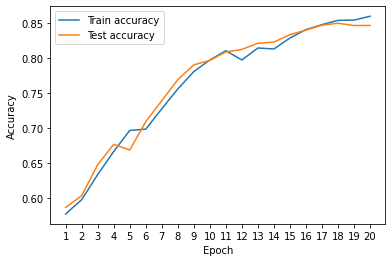

In [42]:
plt.plot(range(1, epochs+1), train_accs_snake, label="Train accuracy")
plt.plot(range(1, epochs+1), test_accs_snake, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, epochs+1))
plt.legend()

Comparison of AUC curves

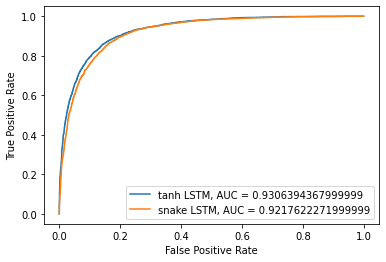

In [78]:
with torch.no_grad():
    preds_test_tanh = net_tanh(torch.Tensor(X_test_pad).long().to(device))
    preds_test_snake = net_snake(torch.Tensor(X_test_pad).long().to(device))
    
fpr_tanh, tpr_tanh, _ = metrics.roc_curve(y_test,  preds_test_tanh.cpu().numpy())
fpr_snake, tpr_snake, _ = metrics.roc_curve(y_test,  preds_test_snake.cpu().numpy())

auc_tanh = metrics.roc_auc_score(y_test, preds_test_tanh.cpu().numpy())
auc_snake = metrics.roc_auc_score(y_test, preds_test_snake.cpu().numpy())

plt.plot(fpr_tanh, tpr_tanh, label="tanh LSTM, AUC = "+str(auc_tanh))
plt.plot(fpr_snake, tpr_snake, label="snake LSTM, AUC = "+str(auc_snake))
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)
plt.show()